In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
import astropy.units as u
import matplotlib.gridspec as gridspec
from astropy.coordinates import Distance
from astropy.cosmology import FlatLambdaCDM
from mcmc_tools import dolinmix_sep, split_data, plotFit_sep, plot_splitdata
from cuts import cosmo_cuts, err_cuts

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.2
matplotlib.rcParams["xtick.major.size"] = 8.0
matplotlib.rcParams["ytick.major.size"] = 8.0
matplotlib.rcParams["xtick.minor.size"] = 3.0
matplotlib.rcParams["ytick.minor.size"] = 3.0
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True

In [2]:
master = pd.read_csv('data/master_v3.1.csv')
master = master[~np.isnan(master.vel)]

In [3]:
found_ana = master[master.foundation == True][['Name','z','vel','vel_err','c_snana','c_err_snana','x0_snana',
                                               'x0_err_snana','x1_snana','x1_err_snana']]
found_ana.rename(columns={'c_snana':'c','c_err_snana':'c_err','x0_snana':'x0','x0_err_snana':'x0_err',
                          'x1_snana':'x1','x1_err_snana':'x1_err'},inplace=True)
found_ana.replace(to_replace='asassn-', value='asassn', inplace=True,regex=True)

csp_ana = master[master.csp == True][['Name','z','vel','vel_err','c_snana','c_err_snana','x0_snana',
                                               'x0_err_snana','x1_snana','x1_err_snana']]
csp_ana.rename(columns={'c_snana':'c','c_err_snana':'c_err','x0_snana':'x0','x0_err_snana':'x0_err',
                          'x1_snana':'x1','x1_err_snana':'x1_err'},inplace=True)

w09_ana = master[master.w09 == True][['Name','z','vel','vel_err','c_snana','c_err_snana','x0_snana',
                                         'x0_err_snana','x1_snana','x1_err_snana']]
w09_ana.rename(columns={'c_snana':'c','c_err_snana':'c_err','x0_snana':'x0','x0_err_snana':'x0_err',
                           'x1_snana':'x1','x1_err_snana':'x1_err'},inplace=True)

In [4]:
c = 299792.458
def pecvelerr(z, pecvelun=300.0):
    pecvelerr = 5.0/np.log(10) * pecvelun/(c*z)
    return pecvelerr
cosmo = FlatLambdaCDM(H0=70.5, Om0=0.3, Tcmb0=2.725)
mu = lambda z: 5.0*np.log10(Distance(z=z, unit=u.pc, cosmology=cosmo).value) - 5.0
mb = lambda x0: -2.5 * np.log10(x0) + 10.635
mberr = lambda x0, x0err: 2.5 * (x0err / x0) / np.log(10)
shpcor = lambda x0, z, x1: mb(x0) - mu(z) + 0.14*x1
shpcor_err = lambda x0, x0err, x1err, z: np.sqrt(mberr(x0, x0err)**2.0 + 
                                                   (0.14*x1err)**2.0 + 
                                                   pecvelerr(z, pecvelun=300.0)**2.0)

In [5]:
found_ana.loc[:,'shp_cor'] = shpcor(found_ana.loc[:,'x0'],found_ana.loc[:,'z'],
                                    found_ana.loc[:,'x1'])
found_ana.loc[:,'shp_cor_err'] = shpcor_err(found_ana.loc[:,'x0'],
                                             found_ana.loc[:,'x0_err'],
                                             found_ana.loc[:,'x1_err'],
                                             found_ana.loc[:,'z'])
##########################################################################################
csp_ana.loc[:,'shp_cor'] = shpcor(csp_ana.loc[:,'x0'],csp_ana.loc[:,'z'],
                                   csp_ana.loc[:,'x1'])
csp_ana.loc[:,'shp_cor_err'] = shpcor_err(csp_ana.loc[:,'x0'],csp_ana.loc[:,'x0_err'],
                                           csp_ana.loc[:,'x1_err'],csp_ana.loc[:,'z'])
##########################################################################################
w09_ana.loc[:,'shp_cor'] = shpcor(w09_ana.loc[:,'x0'],w09_ana.loc[:,'z'],
                                   w09_ana.loc[:,'x1'])
w09_ana.loc[:,'shp_cor_err'] = shpcor_err(w09_ana.loc[:,'x0'],w09_ana.loc[:,'x0_err'],
                                           w09_ana.loc[:,'x1_err'],w09_ana.loc[:,'z'])

In [6]:
found_ana = cosmo_cuts(found_ana)
print(len(found_ana))
csp_ana = cosmo_cuts(csp_ana)
print(len(csp_ana))
w09_ana = cosmo_cuts(w09_ana)
print(len(w09_ana))

69
65
97


In [7]:
def mkCDF(data_tup, bins, data_names, key='c',title=None,hv_loc=(0.15,0.2),lv_loc=(0.15,0.1),xlims=(-0.35,0.35)):
    fig, ax = plt.subplots(1, len(data_tup), sharey=True, gridspec_kw={'wspace':0.0})
    fig.set_size_inches(fig.get_size_inches()[0]*len(data_tup),fig.get_size_inches()[1])
    
    for i, data in enumerate(data_tup):
        ax[i].hist(data[data.vel<-11.8][key].to_numpy(), bins=bins, cumulative=True, density=True, 
                     histtype='step', color='r')
        ax[i].hist(data[data.vel>-11.8][key].to_numpy(), bins=bins, cumulative=True, density=True, 
                     histtype='step', color='b')
        ax[i].text(bins[0],0.8,data_names[i],fontsize=22)
        ax[i].text(hv_loc[0],hv_loc[1],'HV: {}'.format(len(data[data.vel<-11.8][key])),color='red',fontsize=18)
        ax[i].text(lv_loc[0],lv_loc[1],'NV: {}'.format(len(data[data.vel>-11.8][key])),color='blue',fontsize=18)
        ax[i].set_xlim([xlims[0],xlims[1]])
        ax[i].tick_params(axis='x',labelsize=16)
        ax[i].tick_params(axis='y',labelsize=12)
    fig.add_subplot(111,frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    if key=='c':
        plt.xlabel(r'SALT2 $c$', fontsize=20, labelpad=7)
    if key=='mass':
        plt.xlabel(r'$\log(M_{*}/M_{\odot})$', fontsize=20, labelpad=7)
    plt.ylabel('Cumulative Fraction of SNe', fontsize=16, labelpad=7)
    if title is not None:
        plt.title(title, fontsize=20)

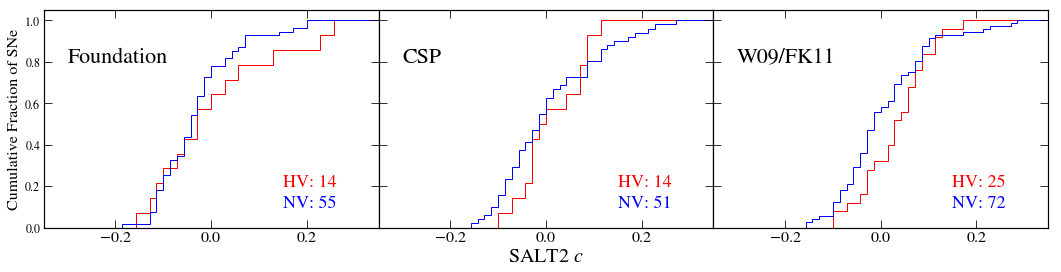

In [8]:
mkCDF((found_ana,csp_ana,w09_ana),np.linspace(-0.3,0.4),('Foundation','CSP','W09/FK11'),
      title=''
#       title='Standard Cosmo Cuts'
     )
plt.savefig('cdfs_figures/cdf_cosmo_cuts.pdf',bbox_inches='tight')
pd.concat([found_ana['Name'],csp_ana['Name'],w09_ana['Name']]).to_csv('data/cdf_standardNames.txt',header=True)

In [9]:
found_ana_x1 = found_ana[(found_ana.x1 > -2) & (found_ana.x1 < 1)]
csp_ana_x1 = csp_ana[(csp_ana.x1 > -2) & (csp_ana.x1 < 1)]
w09_ana_x1 = w09_ana[(w09_ana.x1 > -2) & (w09_ana.x1 < 1)]

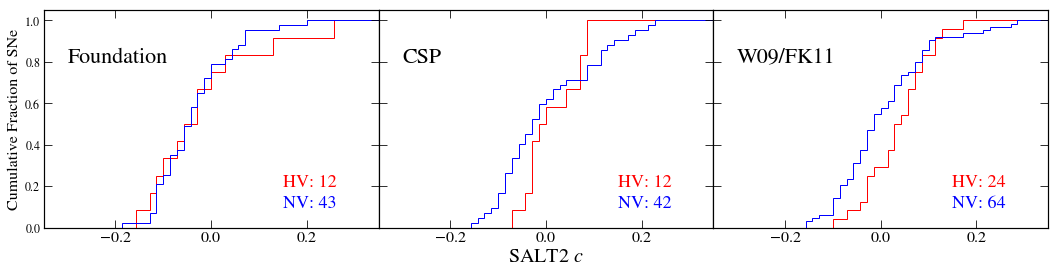

In [10]:
mkCDF((found_ana_x1,csp_ana_x1,w09_ana_x1),np.linspace(-0.3,0.4),('Foundation','CSP','W09/FK11'),
      title=''
#       title=r'$-2<x_1<1$'
     )
plt.savefig('cdfs_figures/cdf_2_x1_1.pdf',bbox_inches='tight')
pd.concat([found_ana_x1['Name'],csp_ana_x1['Name'],w09_ana_x1['Name']]).to_csv('data/cdf_x1Names.txt',header=True)

In [11]:
massvel_werr = pd.read_csv('data/mass_vel_data_expanded_v1.1.dat')
massvel_werr.replace(to_replace='asassn-', value='asassn', inplace=True,regex=True)
massvel_werr = massvel_werr[(~np.isnan(massvel_werr.mass))]
print(len(massvel_werr[massvel_werr.subsample == 'CSP']))
print(len(massvel_werr[massvel_werr.subsample == 'old']))
print(len(massvel_werr[massvel_werr.subsample == 'Foundation']))
# Removing ASASSN-15mi because it is IaPec
massvel_werr = massvel_werr[massvel_werr.Name != 'asassn15mi']
# Removing 1997e because of high mass uncertainty
massvel_werr = massvel_werr[massvel_werr.Name != '1997e']
print(len(massvel_werr[massvel_werr.subsample == 'CSP']))
print(len(massvel_werr[massvel_werr.subsample == 'old']))
print(len(massvel_werr[massvel_werr.subsample == 'Foundation']))

massvel_werr.loc[massvel_werr['mass'] < 7.0,'masserr'] = 0.0
# Those objects with mass = 5.0 are placeholder values, for the sake of asthetics and because their
# actual mass is low, but essentially unknown, we will set their value higher
massvel_werr.loc[massvel_werr['mass'] == 5.0,'mass'] = 7.0
massvel_werr.sort_values(by='mass').head()

65
117
77
65
116
76


,Unnamed: 0,Unnamed: 0.1,Host,Name,mass,mass_Burns18,mass_DES,mass_Jones18,mass_Neill,mass_PanSTARRS,...,mass_Wolf,masserr,subsample,symbol,vel,velerr,z,mass_Chang,mass_2MASS,mass_Conley11
21,21,94,NaN,ps15bwh,7.000,NaN,NaN,5.000,NaN,NaN,...,NaN,0.000000,Foundation,<,-11.320640,0.256279,NaN,NaN,NaN,NaN
18,18,86,NaN,atlas16agv,7.000,NaN,NaN,5.000,NaN,NaN,...,NaN,0.000000,Foundation,<,-10.100120,0.230585,NaN,NaN,NaN,NaN
32,32,121,NaN,2017coa,7.575,NaN,NaN,7.575,NaN,NaN,...,NaN,0.158451,Foundation,o,-10.774048,0.222075,NaN,NaN,NaN,NaN
158,158,296,SDSS J103944.53+150204.7,2016ixf,7.874,NaN,NaN,7.874,NaN,NaN,...,NaN,0.158451,Foundation,o,-10.842655,0.220531,0.06602,NaN,NaN,NaN
20,20,90,NaN,css160129,8.160,NaN,NaN,NaN,NaN,NaN,...,NaN,0.158451,Foundation,s,-11.867747,0.222706,NaN,NaN,NaN,NaN


In [12]:
found_mass = pd.merge(found_ana, massvel_werr[['Name','mass','masserr']], on='Name')
print(len(found_mass))
csp_mass = pd.merge(csp_ana, massvel_werr[['Name','mass','masserr']], on='Name')
print(len(csp_mass))
w09_mass = pd.merge(w09_ana, massvel_werr[['Name','mass','masserr']], on='Name')
print(len(w09_mass))

65
61
68


This plot is useful as a diagnostic as we will make a CDF with cuts based on host mass, however, not every SN has a host mass measurement. Therefore this plot can be used as a comparison for how the distributions change based on cuts to host mass measurement.

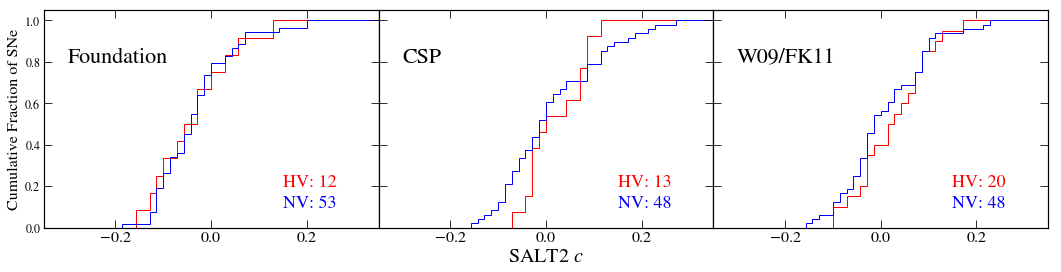

In [13]:
mkCDF((found_mass,csp_mass,w09_mass),np.linspace(-0.3,0.4), ('Foundation','CSP','W09/FK11'),
      title=''
#       title='Has Host Mass Measurement'
     )
plt.savefig('cdfs_figures/cdf_mass.pdf',bbox_inches='tight')

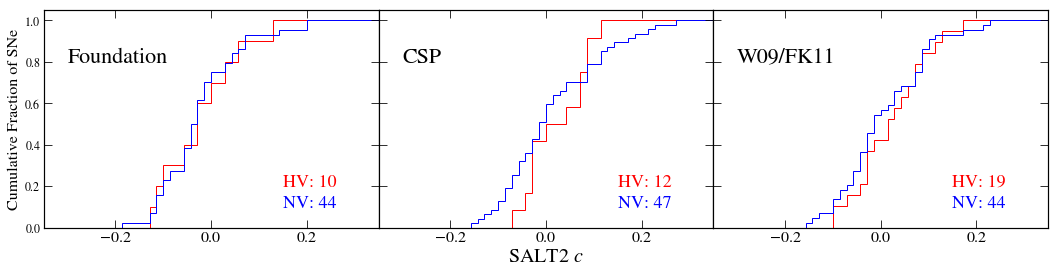

In [14]:
mkCDF((found_mass[found_mass.mass>9.5],csp_mass[csp_mass.mass>9.5],w09_mass[w09_mass.mass>9.5]),
      np.linspace(-0.3,0.4), ('Foundation','CSP','W09/FK11'),
      title=''
#       title=r'$\log(M_{*}/M_{\odot}) > 9.5$'
     )
plt.savefig('cdfs_figures/cdf_mass_95.pdf',bbox_inches='tight')
pd.concat([found_mass[found_mass.mass>9.5]['Name'],csp_mass[csp_mass.mass>9.5]['Name'],w09_mass[w09_mass.mass>9.5]['Name']]).to_csv('data/cdf_mass95Names.txt',header=True)